In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
import tqdm

In [2]:
sys.path.append("../")

In [3]:
from Transformers import ChannelsFirst, ToTensor, Rescale, splitter

In [4]:
from DataSets import UNetDataSetFromNpz

In [5]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT
train_test = os.path.join(data_dir, "train_validation_test")

In [9]:
data = np.load(os.path.join(train_test,"Xy_train+val_clean_300_24_10_25.npz"))
x = data["x"]
y = data['y']
dist = data['dist']
class_dist = np.unique(data['dist'], return_inverse=True)[1]

In [10]:
composed = transforms.Compose([Rescale(.25), ChannelsFirst(), ToTensor()])

In [12]:
dataset = UNetDataSetFromNpz(x, y, transform=composed, dist = dist[...,np.newaxis])

In [13]:
data_loaders, data_lengths = splitter(dataset, validation_split=0.2, batch=16, workers=4)

In [14]:
torch.cuda.empty_cache() 

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [17]:
model = cUNet(out_size=1)

In [18]:
criterion_mask = dice_loss

In [19]:
criterion_class = nn.MSELoss()

In [20]:
model.to(device)

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

In [21]:
import torch.optim as optim


optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [22]:
epochs = 50

In [23]:
coeff_mask = 0.75

In [26]:
for epoch in tqdm.tqdm(range(epochs)):
    print("Epoch {}/{}\n".format(epoch+1, epochs))
    print('-'* 10)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train(True)
        else:
            model.train(False)
            
        running_loss = 0.0
        for i, batch in enumerate(data_loaders[phase]):
            inputs = batch['image'].float().to(device)
            labels_mask = batch['mask'].float().to(device)
            labels_dist = batch['dist'].float().to(device)
            #print(inputs.is_cuda, labels_mask.is_cuda, labels_dist.is_cuda)
            optimizer.zero_grad()
            out_mask, out_class  = model(inputs)
            #print(out_mask.is_cuda)
            #print(out_class.is_cuda)
            loss_mask = criterion_mask(out_mask, labels_mask)
            loss_class = criterion_class(out_class, labels_dist)
            loss = coeff_mask * loss_mask + (1-coeff_mask) * loss_class
            #print(loss_mask, loss_class)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # print statistics
            running_loss += loss.item()
        epoch_loss = running_loss / data_lengths[phase]
        print('{} Loss: {:.4f}'.format(phase, epoch_loss))
print('Finished Training')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50

----------
train Loss: 1.6298


  2%|▏         | 1/50 [00:42<34:25, 42.14s/it]

val Loss: 1.3236
Epoch 2/50

----------
train Loss: 1.2847


  4%|▍         | 2/50 [01:23<33:33, 41.95s/it]

val Loss: 1.3159
Epoch 3/50

----------
train Loss: 1.2781


  6%|▌         | 3/50 [02:05<32:43, 41.77s/it]

val Loss: 1.3171
Epoch 4/50

----------
train Loss: 1.2623


  8%|▊         | 4/50 [02:46<31:57, 41.69s/it]

val Loss: 1.3678
Epoch 5/50

----------
train Loss: 1.2938


 10%|█         | 5/50 [03:28<31:14, 41.65s/it]

val Loss: 1.3921
Epoch 6/50

----------
train Loss: 1.2695


 12%|█▏        | 6/50 [04:09<30:31, 41.63s/it]

val Loss: 1.3128
Epoch 7/50

----------
train Loss: 1.2552


 14%|█▍        | 7/50 [04:50<29:40, 41.42s/it]

val Loss: 1.3550
Epoch 8/50

----------
train Loss: 1.2509


 16%|█▌        | 8/50 [05:32<29:00, 41.43s/it]

val Loss: 1.2993
Epoch 9/50

----------
train Loss: 1.2293


 18%|█▊        | 9/50 [06:13<28:18, 41.43s/it]

val Loss: 1.3468
Epoch 10/50

----------
train Loss: 1.1439


 20%|██        | 10/50 [06:54<27:33, 41.33s/it]

val Loss: 1.1581
Epoch 11/50

----------
train Loss: 0.3805


 22%|██▏       | 11/50 [07:36<27:04, 41.64s/it]

val Loss: 0.0185
Epoch 12/50

----------
train Loss: 0.0017


 24%|██▍       | 12/50 [08:18<26:21, 41.63s/it]

val Loss: 0.0017
Epoch 13/50

----------
train Loss: -0.0047


 26%|██▌       | 13/50 [08:59<25:37, 41.56s/it]

val Loss: -0.0225
Epoch 14/50

----------
train Loss: -0.0225


 28%|██▊       | 14/50 [09:41<24:58, 41.61s/it]

val Loss: -0.0282
Epoch 15/50

----------
train Loss: -0.0306


 30%|███       | 15/50 [10:22<24:13, 41.52s/it]

val Loss: -0.0271
Epoch 16/50

----------
train Loss: -0.0354


 32%|███▏      | 16/50 [11:04<23:30, 41.49s/it]

val Loss: -0.0388
Epoch 17/50

----------
train Loss: -0.0393


 34%|███▍      | 17/50 [11:45<22:49, 41.51s/it]

val Loss: -0.0412
Epoch 18/50

----------
train Loss: -0.0410


 36%|███▌      | 18/50 [12:26<22:02, 41.33s/it]

val Loss: -0.0411
Epoch 19/50

----------
train Loss: -0.0415


 38%|███▊      | 19/50 [13:09<21:30, 41.63s/it]

val Loss: -0.0418
Epoch 20/50

----------
train Loss: -0.0422


 40%|████      | 20/50 [13:51<20:52, 41.73s/it]

val Loss: -0.0425
Epoch 21/50

----------
train Loss: -0.0423


 42%|████▏     | 21/50 [14:32<20:03, 41.50s/it]

val Loss: -0.0426
Epoch 22/50

----------
train Loss: -0.0426


 44%|████▍     | 22/50 [15:14<19:26, 41.66s/it]

val Loss: -0.0429
Epoch 23/50

----------
train Loss: -0.0426


 46%|████▌     | 23/50 [15:55<18:45, 41.69s/it]

val Loss: -0.0430
Epoch 24/50

----------
train Loss: -0.0425


 48%|████▊     | 24/50 [16:38<18:09, 41.90s/it]

val Loss: -0.0428
Epoch 25/50

----------
train Loss: -0.0428


 50%|█████     | 25/50 [17:19<17:22, 41.71s/it]

val Loss: -0.0429
Epoch 26/50

----------
train Loss: -0.0426


 52%|█████▏    | 26/50 [18:01<16:39, 41.64s/it]

val Loss: -0.0420
Epoch 27/50

----------
train Loss: -0.0424


 54%|█████▍    | 27/50 [18:42<15:53, 41.46s/it]

val Loss: -0.0430
Epoch 28/50

----------
train Loss: -0.0426


 56%|█████▌    | 28/50 [19:24<15:19, 41.80s/it]

val Loss: -0.0428
Epoch 29/50

----------
train Loss: -0.0428


 58%|█████▊    | 29/50 [20:06<14:37, 41.78s/it]

val Loss: -0.0432
Epoch 30/50

----------
train Loss: -0.0429


 60%|██████    | 30/50 [20:48<13:54, 41.74s/it]

val Loss: -0.0431
Epoch 31/50

----------
train Loss: -0.0430


 62%|██████▏   | 31/50 [21:29<13:13, 41.76s/it]

val Loss: -0.0431
Epoch 32/50

----------
train Loss: -0.0428


 64%|██████▍   | 32/50 [22:11<12:28, 41.59s/it]

val Loss: -0.0424
Epoch 33/50

----------
train Loss: -0.0429


 66%|██████▌   | 33/50 [22:52<11:46, 41.54s/it]

val Loss: -0.0431
Epoch 34/50

----------
train Loss: -0.0429


 68%|██████▊   | 34/50 [23:33<11:04, 41.50s/it]

val Loss: -0.0432
Epoch 35/50

----------
train Loss: -0.0431


 70%|███████   | 35/50 [24:15<10:24, 41.62s/it]

val Loss: -0.0427
Epoch 36/50

----------
train Loss: -0.0431


 72%|███████▏  | 36/50 [24:56<09:39, 41.42s/it]

val Loss: -0.0431
Epoch 37/50

----------
train Loss: -0.0428


 74%|███████▍  | 37/50 [25:38<09:00, 41.59s/it]

val Loss: -0.0434
Epoch 38/50

----------
train Loss: -0.0431


 76%|███████▌  | 38/50 [26:19<08:17, 41.46s/it]

val Loss: -0.0420
Epoch 39/50

----------
train Loss: -0.0426


 78%|███████▊  | 39/50 [27:01<07:37, 41.58s/it]

val Loss: -0.0434
Epoch 40/50

----------
train Loss: -0.0429


 80%|████████  | 40/50 [27:43<06:56, 41.67s/it]

val Loss: -0.0435
Epoch 41/50

----------
train Loss: -0.0432


 82%|████████▏ | 41/50 [28:24<06:12, 41.42s/it]

val Loss: -0.0435
Epoch 42/50

----------
train Loss: -0.0433


 84%|████████▍ | 42/50 [29:05<05:30, 41.33s/it]

val Loss: -0.0436
Epoch 43/50

----------
train Loss: -0.0431


 86%|████████▌ | 43/50 [29:47<04:50, 41.44s/it]

val Loss: -0.0420
Epoch 44/50

----------
train Loss: -0.0431


 88%|████████▊ | 44/50 [30:29<04:10, 41.69s/it]

val Loss: -0.0435
Epoch 45/50

----------
train Loss: -0.0433


 90%|█████████ | 45/50 [31:10<03:27, 41.56s/it]

val Loss: -0.0433
Epoch 46/50

----------
train Loss: -0.0431


 92%|█████████▏| 46/50 [31:52<02:46, 41.67s/it]

val Loss: -0.0435
Epoch 47/50

----------
train Loss: -0.0433


 94%|█████████▍| 47/50 [32:34<02:05, 41.80s/it]

val Loss: -0.0435
Epoch 48/50

----------
train Loss: -0.0433


 96%|█████████▌| 48/50 [33:17<01:23, 41.99s/it]

val Loss: -0.0433
Epoch 49/50

----------
train Loss: -0.0432


 98%|█████████▊| 49/50 [33:59<00:41, 41.96s/it]

val Loss: -0.0437
Epoch 50/50

----------
train Loss: -0.0434


100%|██████████| 50/50 [34:40<00:00, 41.82s/it]

val Loss: -0.0432
Finished Training


In [6]:
epochs = 50
coeff_mask = 0.75

In [7]:
model_name = "../model/trained_cUNet_pytorch_regression_{}epochs_coeff_mask{}_validation.pkl".format(epochs, coeff_mask)

In [28]:
torch.save(model.state_dict(), model_name)

In [10]:
model_inference = cUNet(out_size=1)

In [11]:
model_inference.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [31]:
test_data = np.load(os.path.join(train_test,"Xy_test_clean_300_24_10_25.npz"))
x_test = test_data["x"]
y_test = test_data['y']
dist_test = test_data['dist']
dist_test_idx = np.unique(dist_test, return_inverse=True)[1]

In [33]:
test_dataset = UNetDataSetFromNpz(x_test, y_test, transform=composed, dist = dist_test)

test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

In [34]:
model_inference = model.eval()

In [35]:
model_inference.to(device)

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

In [36]:
import matplotlib.pyplot as plt

In [30]:
dist_dict = {str(idx):cl  for (cl, idx) in 
             zip(np.unique(dist_test), np.unique(dist_test_idx))}

batch 1
1: true_dist: 25, pred_dist: [24.92538]


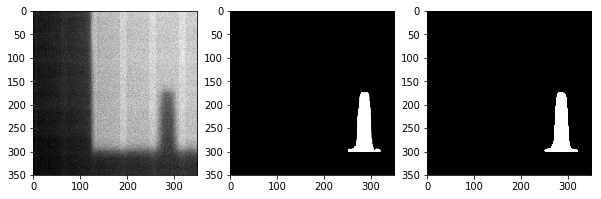

2: true_dist: 10, pred_dist: [9.835019]


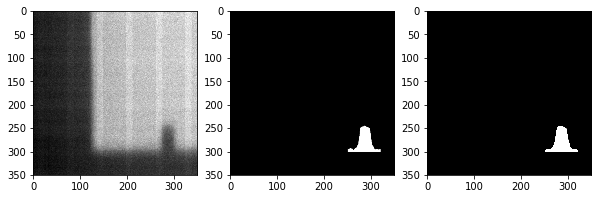

3: true_dist: 2, pred_dist: [1.7900528]


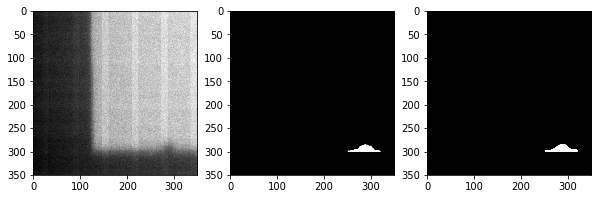

4: true_dist: 25, pred_dist: [24.801111]


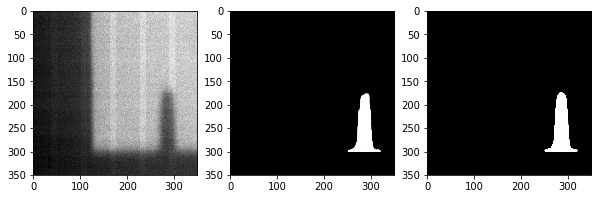

5: true_dist: 4, pred_dist: [3.8847785]


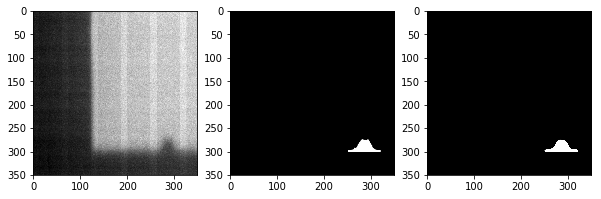

6: true_dist: 10, pred_dist: [9.962265]


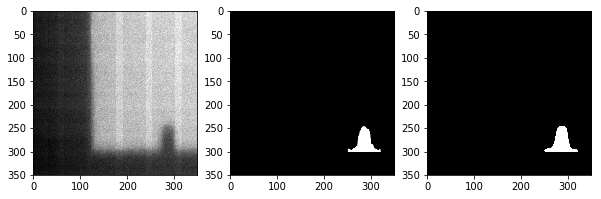

7: true_dist: 2, pred_dist: [1.9109125]


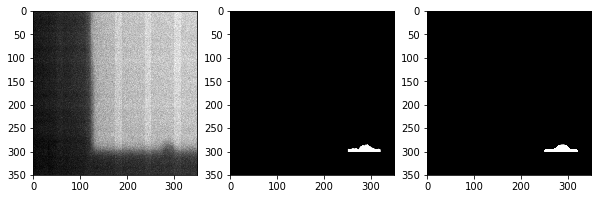

8: true_dist: 10, pred_dist: [9.869321]


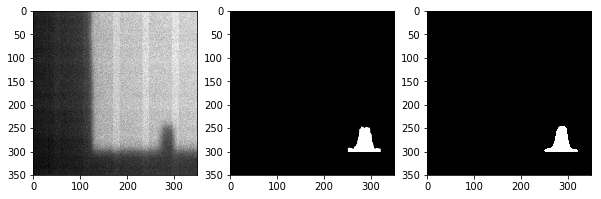

9: true_dist: 25, pred_dist: [24.949186]


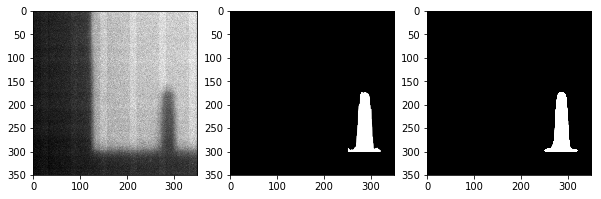

10: true_dist: 2, pred_dist: [1.7647144]


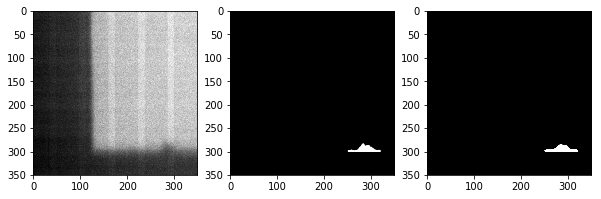

11: true_dist: 2, pred_dist: [1.911153]


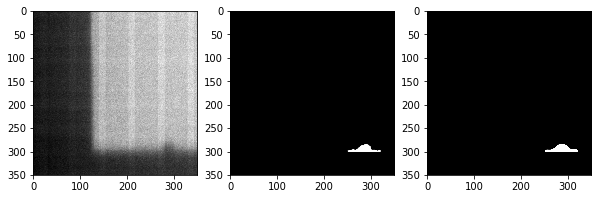

12: true_dist: 2, pred_dist: [1.7279847]


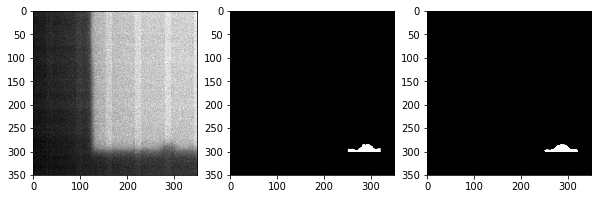

13: true_dist: 10, pred_dist: [9.754532]


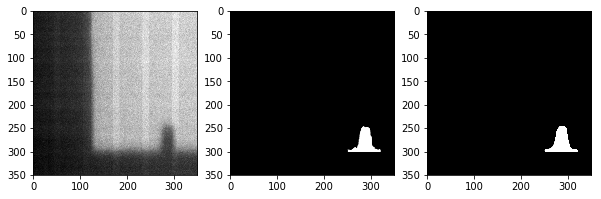

14: true_dist: 2, pred_dist: [1.8810902]


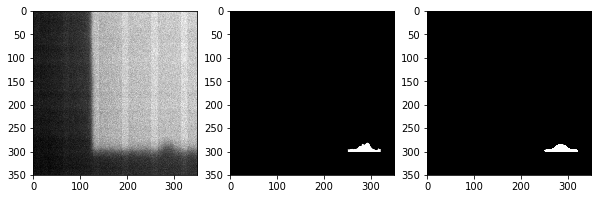

15: true_dist: 10, pred_dist: [9.782081]


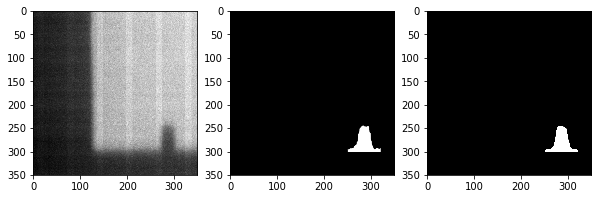

16: true_dist: 10, pred_dist: [9.676797]


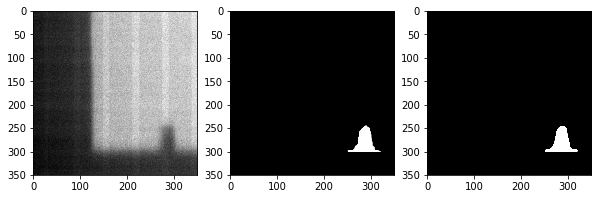

batch 2
1: true_dist: 10, pred_dist: [9.817665]


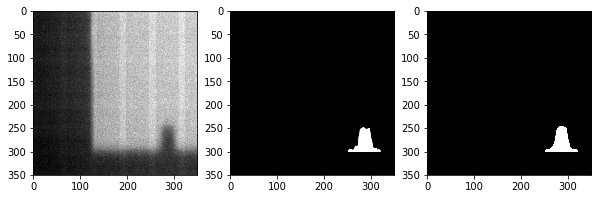

2: true_dist: 25, pred_dist: [24.822052]


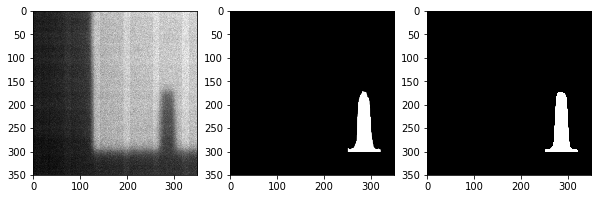

3: true_dist: 10, pred_dist: [9.903238]


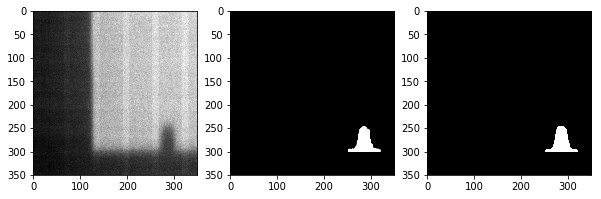

4: true_dist: 10, pred_dist: [9.7850685]


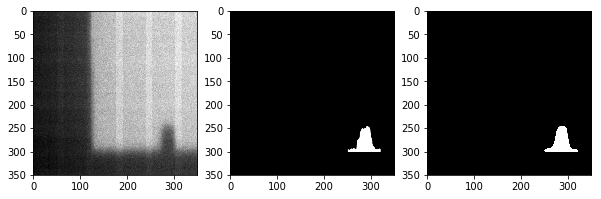

5: true_dist: 2, pred_dist: [1.9532844]


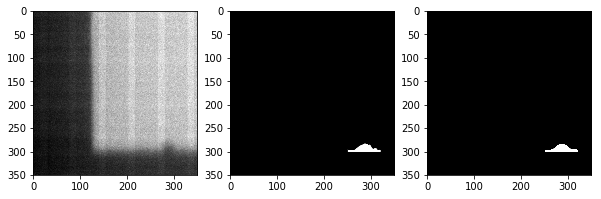

6: true_dist: 4, pred_dist: [3.8150883]


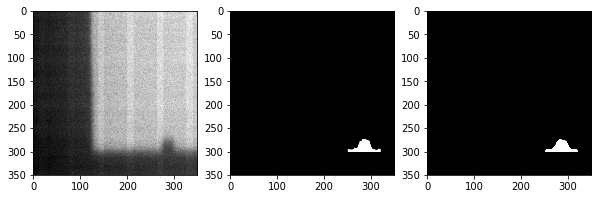

7: true_dist: 25, pred_dist: [24.894493]


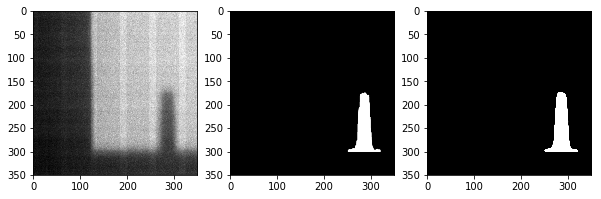

8: true_dist: 4, pred_dist: [3.9333634]


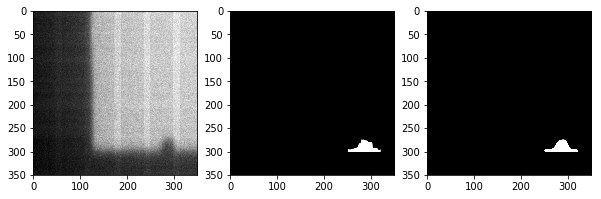

9: true_dist: 25, pred_dist: [24.697803]


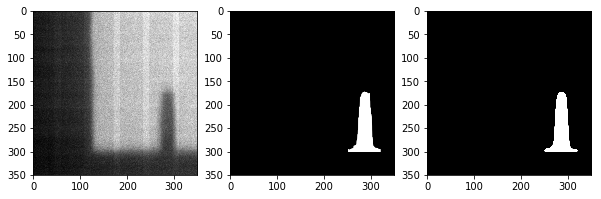

10: true_dist: 10, pred_dist: [9.59987]


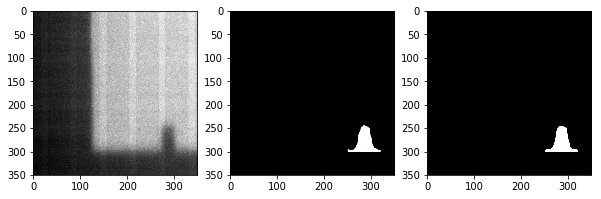

11: true_dist: 2, pred_dist: [1.7834458]


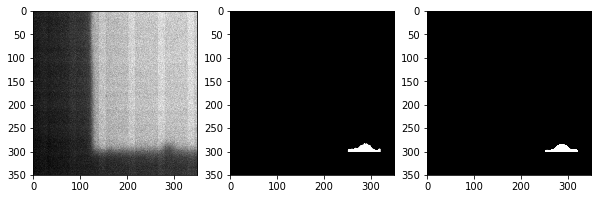

12: true_dist: 4, pred_dist: [3.8874085]


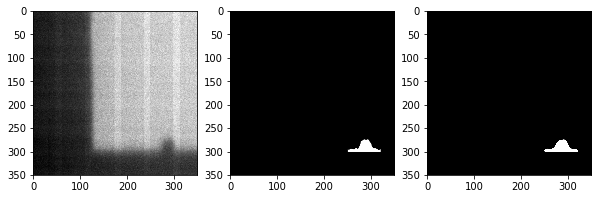

13: true_dist: 10, pred_dist: [9.620036]


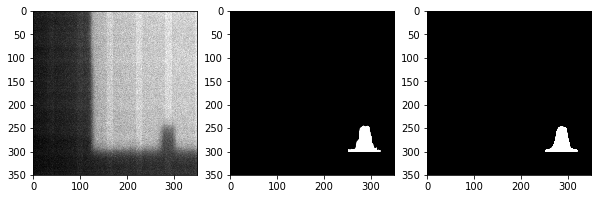

14: true_dist: 2, pred_dist: [1.8647844]


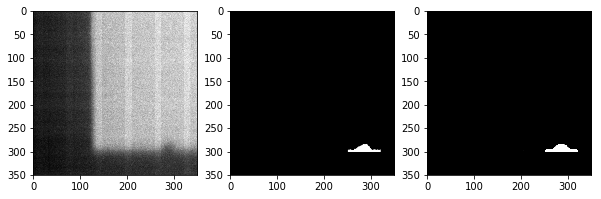

15: true_dist: 25, pred_dist: [24.702023]


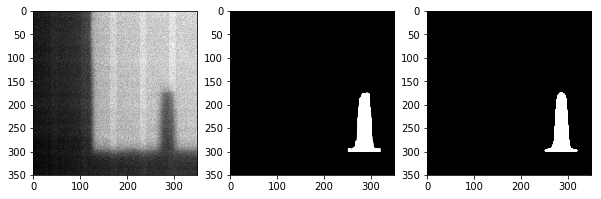

16: true_dist: 10, pred_dist: [9.610137]


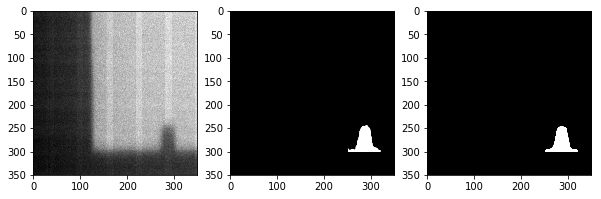

In [37]:
for i, batch in enumerate(test_data_loader):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_cl, pr_msk, pr_cl) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = tr_cl
        pred_dist = pr_cl
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [38]:
y_test = []
y_pred = []
for i, batch in enumerate(test_data_loader):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_cl, pr_cl) in enumerate(zip(true_images,
                                                 true_dists.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = tr_cl
        pred_dist = pr_cl
        y_test.append(true_dist)
        y_pred.append(pred_dist)

batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15


In [39]:
15*16

240

In [40]:
torch.cuda.empty_cache() 

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [42]:
mean_squared_error(y_test, y_pred)

0.048021637176211364

In [43]:
mean_absolute_error(y_test, y_pred)

0.19423905511697134

#### Test on 15mm

In [13]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT

In [14]:
data_15mm = os.path.join(data_dir,"dataset", "first_batch", "10x10_15mm_clean")

In [8]:
from DataSets import UNetDatasetFromFolders

In [9]:
from Transformers import Cut

In [10]:
composed = transforms.Compose([Cut(),Rescale(.25), ChannelsFirst(), ToTensor()])

In [18]:
dataset_15mm = UNetDatasetFromFolders(data_15mm, transform=composed)

In [19]:
data_15mm_loader = DataLoader(dataset_15mm, batch_size=16, shuffle=True, num_workers=4)

In [21]:
model_name = "../model/trained_cUNet_pytorch_regression_{}epochs_coeff_mask{}_validation.pkl".format(epochs, coeff_mask)
model_inference = cUNet(out_size=1)

model_inference.load_state_dict(torch.load(model_name))


<All keys matched successfully>

In [51]:
model_inference.eval()
model_inference.to(device)

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

In [23]:
len(dataset_15mm)

300

In [24]:
for i, batch in enumerate(data_15mm_loader):
    print(batch['image'].size(), batch['mask'].size(), batch['dist'].size())
    if i==1:
        break

torch.Size([16, 1, 350, 350]) torch.Size([16, 1, 350, 350]) torch.Size([16])
torch.Size([16, 1, 350, 350]) torch.Size([16, 1, 350, 350]) torch.Size([16])


In [26]:
import matplotlib.pyplot as plt

batch 1
1: true_dist: 15, pred_dist: [15.229705]


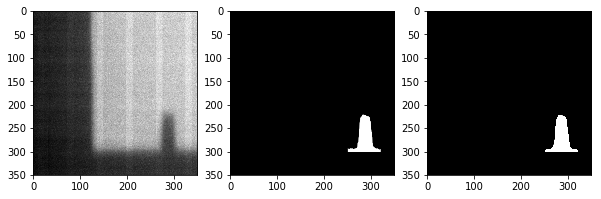

2: true_dist: 15, pred_dist: [15.133314]


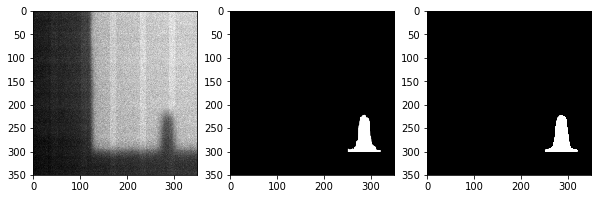

3: true_dist: 15, pred_dist: [15.453735]


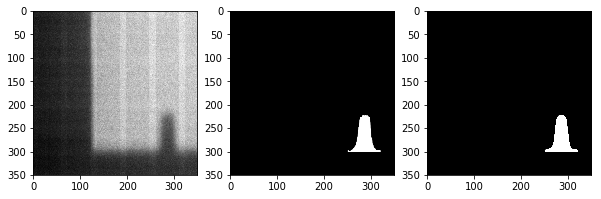

4: true_dist: 15, pred_dist: [15.569233]


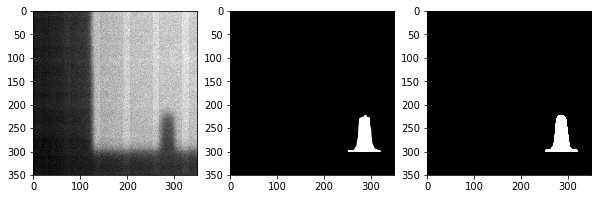

5: true_dist: 15, pred_dist: [15.278799]


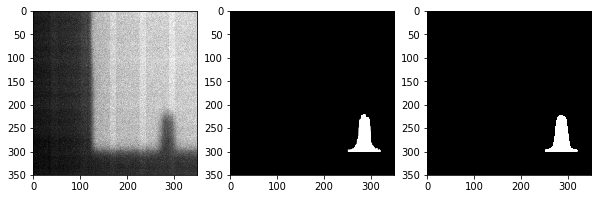

6: true_dist: 15, pred_dist: [15.099553]


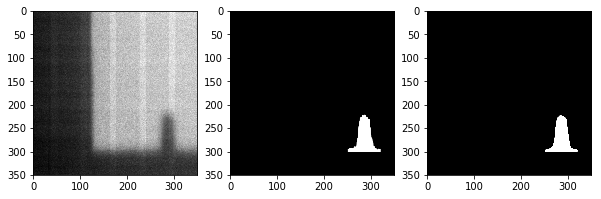

7: true_dist: 15, pred_dist: [15.3854885]


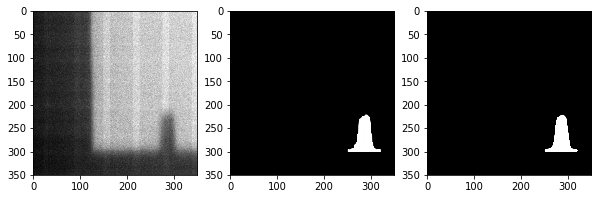

8: true_dist: 15, pred_dist: [15.2539015]


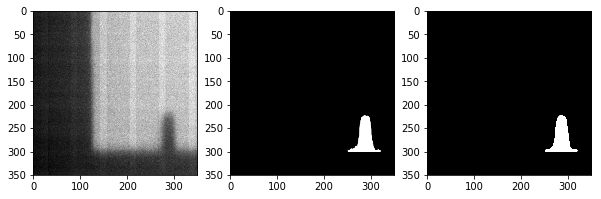

9: true_dist: 15, pred_dist: [15.362645]


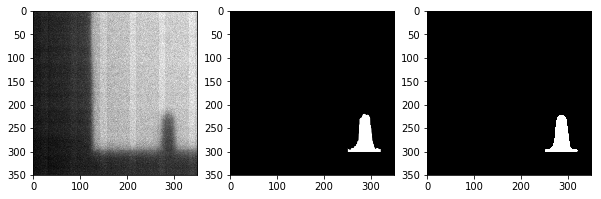

10: true_dist: 15, pred_dist: [15.37427]


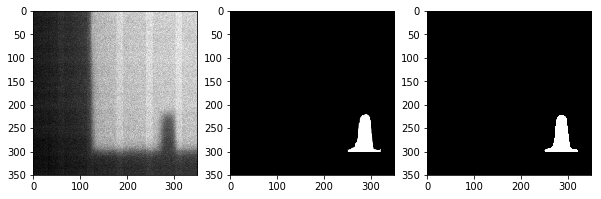

11: true_dist: 15, pred_dist: [15.252347]


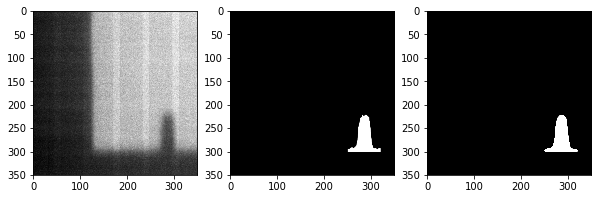

12: true_dist: 15, pred_dist: [15.354904]


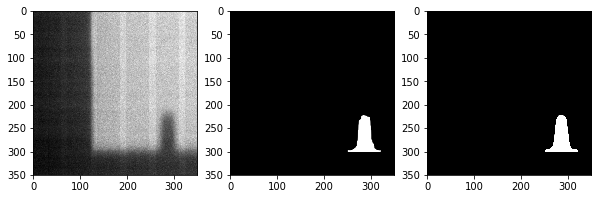

13: true_dist: 15, pred_dist: [15.382765]


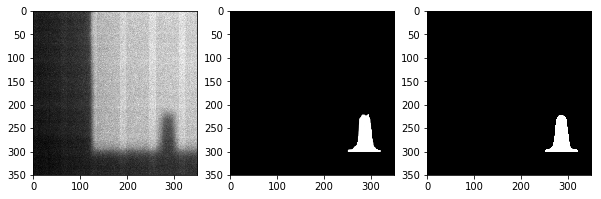

14: true_dist: 15, pred_dist: [15.084273]


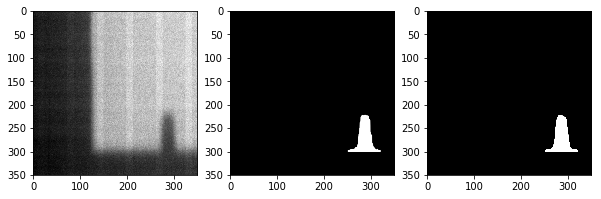

15: true_dist: 15, pred_dist: [15.27826]


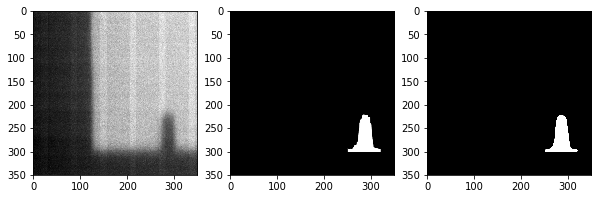

16: true_dist: 15, pred_dist: [15.045748]


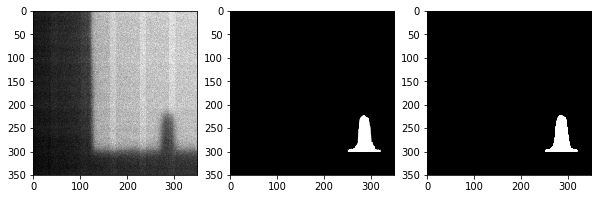

batch 2
1: true_dist: 15, pred_dist: [15.314367]


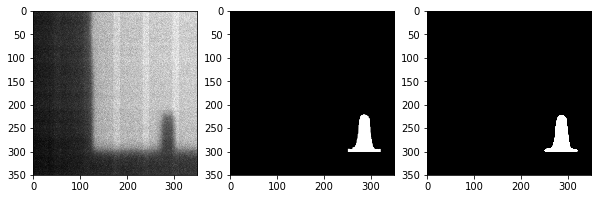

2: true_dist: 15, pred_dist: [15.353536]


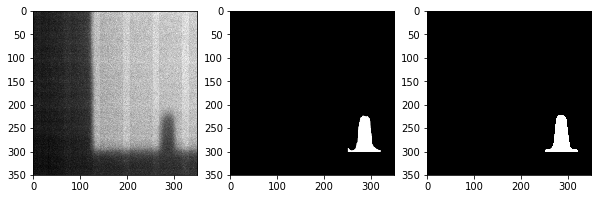

3: true_dist: 15, pred_dist: [15.349012]


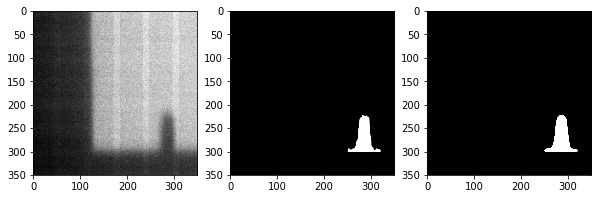

4: true_dist: 15, pred_dist: [15.271038]


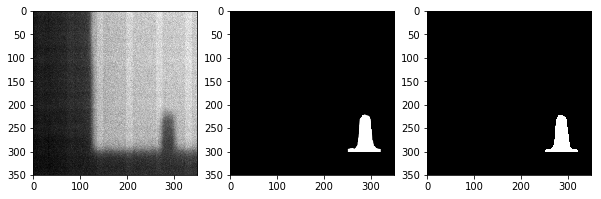

5: true_dist: 15, pred_dist: [15.130029]


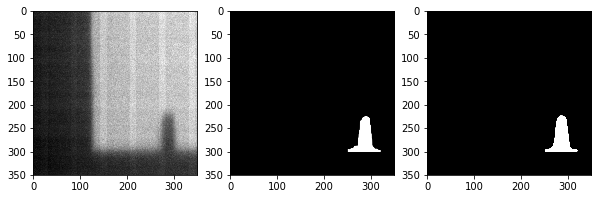

6: true_dist: 15, pred_dist: [15.361388]


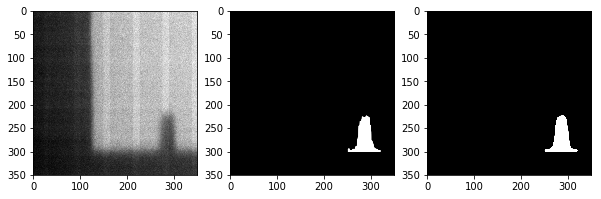

7: true_dist: 15, pred_dist: [15.4340515]


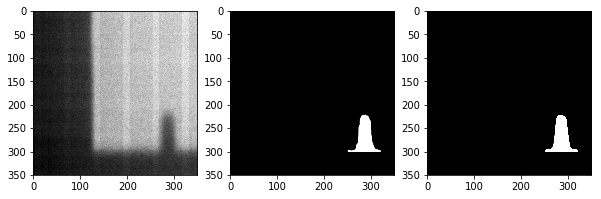

8: true_dist: 15, pred_dist: [15.120232]


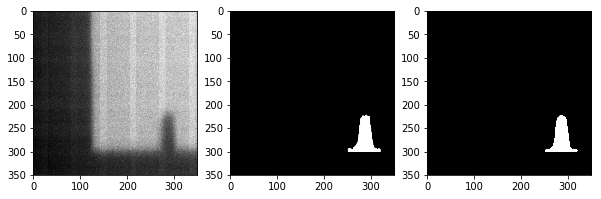

9: true_dist: 15, pred_dist: [15.364317]


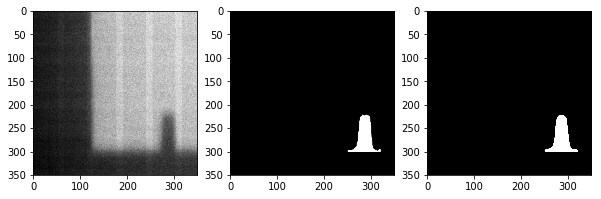

10: true_dist: 15, pred_dist: [15.154061]


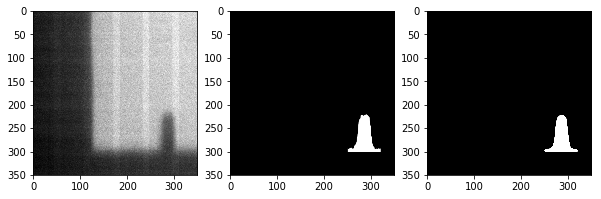

11: true_dist: 15, pred_dist: [15.4912]


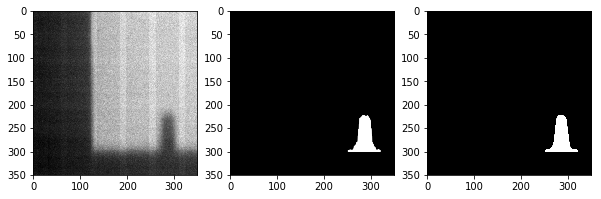

12: true_dist: 15, pred_dist: [15.275324]


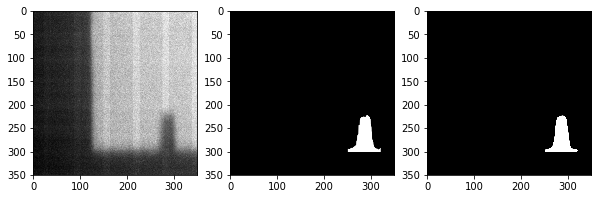

13: true_dist: 15, pred_dist: [15.416114]


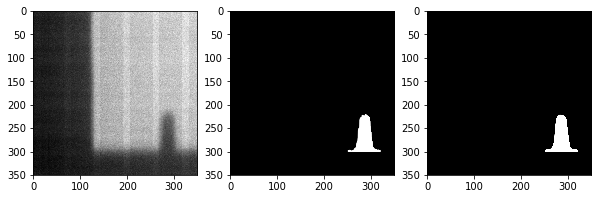

14: true_dist: 15, pred_dist: [15.425612]


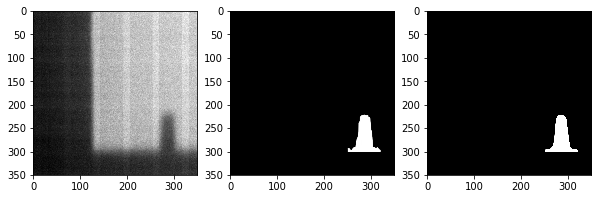

15: true_dist: 15, pred_dist: [15.340548]


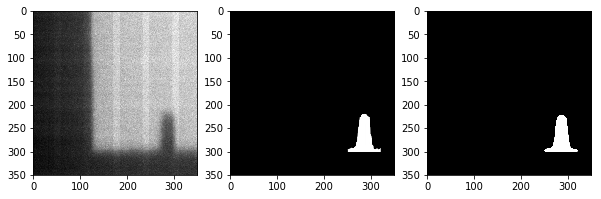

16: true_dist: 15, pred_dist: [15.062716]


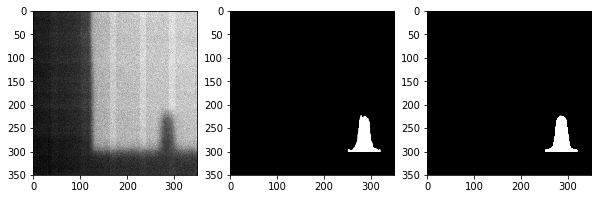

In [40]:
for i, batch in enumerate(data_15mm_loader):

    true_images, true_masks, true_dists = batch['image'].transpose(2,3), batch['mask'].transpose(2,3), batch['dist']
    pred_masks, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_cl, pr_msk, pr_cl) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = tr_cl
        pred_dist = pr_cl
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [48]:
y_15mm_test = []
y_15mm_pred = []
for i, batch in enumerate(data_15mm_loader):
    true_images, true_dists = batch['image'].transpose(2,3), batch['dist']
    _, pred_dists = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_dist, pr_dist) in enumerate(zip(true_images,
                                                 true_dists.cpu().detach().numpy(), 
                                                 pred_dists.cpu().detach().numpy())):
        print("item {}".format(j+1))
        true_dist = tr_dist
        pred_dist = pr_dist
        y_15mm_test.append(true_dist)
        y_15mm_pred.append(pred_dist)

batch 1
item 1
item 2
item 3
item 4
item 5
item 6
item 7
item 8
item 9
item 10
item 11
item 12
item 13
item 14
item 15
item 16
batch 2
item 1
item 2
item 3
item 4
item 5
item 6
item 7
item 8
item 9
item 10
item 11
item 12
item 13
item 14
item 15
item 16
batch 3
item 1
item 2
item 3
item 4
item 5
item 6
item 7
item 8
item 9
item 10
item 11
item 12
item 13
item 14
item 15
item 16
batch 4
item 1
item 2
item 3
item 4
item 5
item 6
item 7
item 8
item 9
item 10
item 11
item 12
item 13
item 14
item 15
item 16
batch 5
item 1
item 2
item 3
item 4
item 5
item 6
item 7
item 8
item 9
item 10
item 11
item 12
item 13
item 14
item 15
item 16
batch 6
item 1
item 2
item 3
item 4
item 5
item 6
item 7
item 8
item 9
item 10
item 11
item 12
item 13
item 14
item 15
item 16
batch 7
item 1
item 2
item 3
item 4
item 5
item 6
item 7
item 8
item 9
item 10
item 11
item 12
item 13
item 14
item 15
item 16
batch 8
item 1
item 2
item 3
item 4
item 5
item 6
item 7
item 8
item 9
item 10
item 11
item 12
item 13
item 14


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [46]:
mean_squared_error(y_15mm_test, y_15mm_pred)

0.1019331318606722

In [47]:
mean_absolute_error(y_15mm_test, y_15mm_pred)

0.29980164845784507

#### test on the complete dataset

In [11]:
dataset_folder = os.path.join(data_dir,"dataset", "first_batch")

In [12]:
dataset = UNetDatasetFromFolders(dataset_folder, transform=composed)

dataset_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

In [16]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [17]:
model_inference = cUNet(out_size=1)

model_inference.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [20]:
model_inference.eval()

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

In [21]:
model_inference.to(device)

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

In [22]:
len(dataset)

3000

In [26]:
import matplotlib.pyplot as plt

batch 1
1: true_dist: 2, pred_dist: [1.9034727]


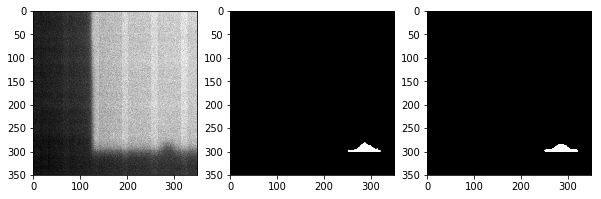

2: true_dist: 15, pred_dist: [15.328129]


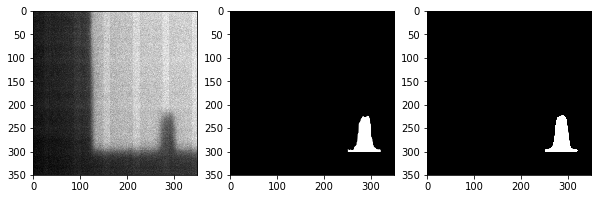

3: true_dist: 3, pred_dist: [2.7918997]


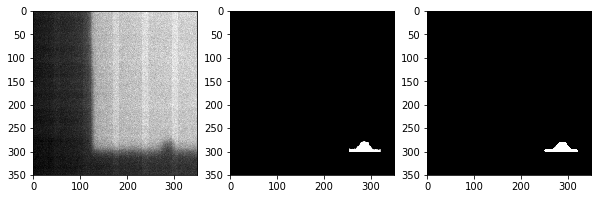

4: true_dist: 2, pred_dist: [1.8843595]


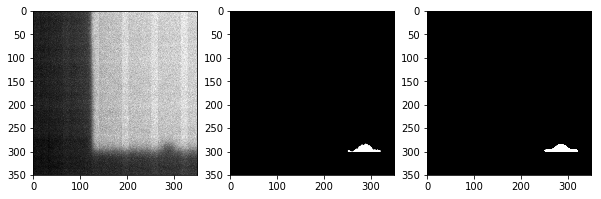

5: true_dist: 30, pred_dist: [27.25568]


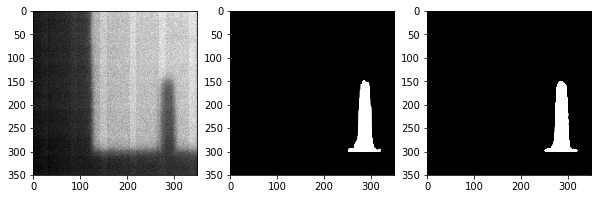

6: true_dist: 30, pred_dist: [27.19512]


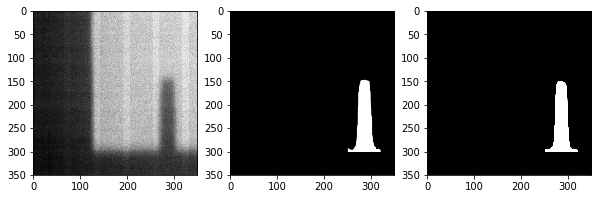

7: true_dist: 25, pred_dist: [24.61002]


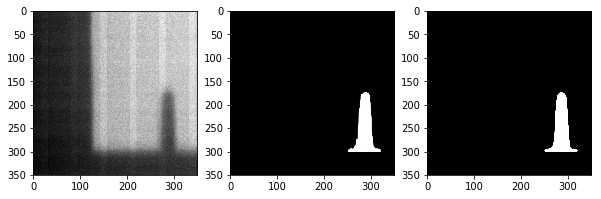

8: true_dist: 3, pred_dist: [2.785254]


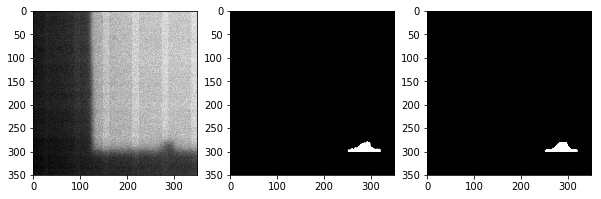

9: true_dist: 35, pred_dist: [28.629145]


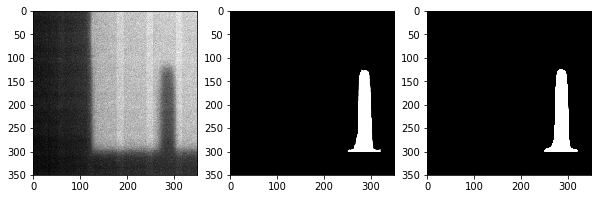

10: true_dist: 35, pred_dist: [28.819633]


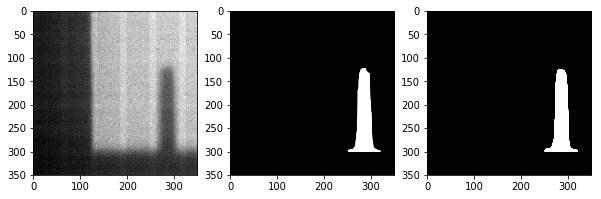

11: true_dist: 20, pred_dist: [20.294817]


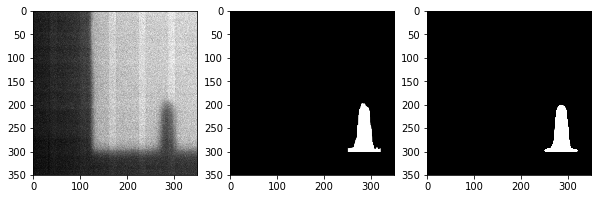

12: true_dist: 15, pred_dist: [15.131906]


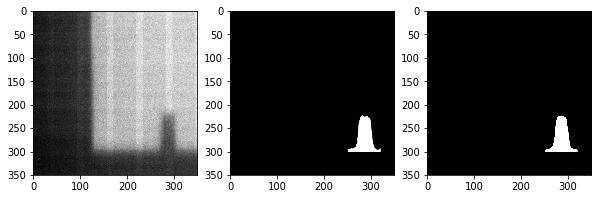

13: true_dist: 10, pred_dist: [9.672497]


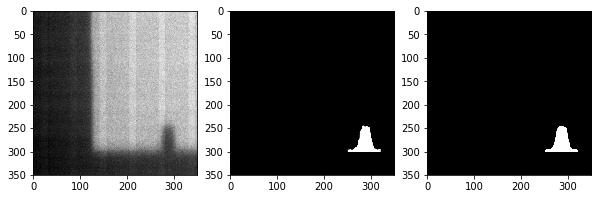

14: true_dist: 1, pred_dist: [1.1395913]


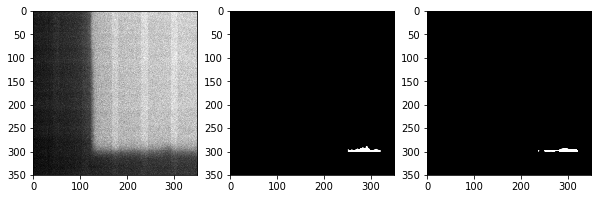

15: true_dist: 2, pred_dist: [1.8335159]


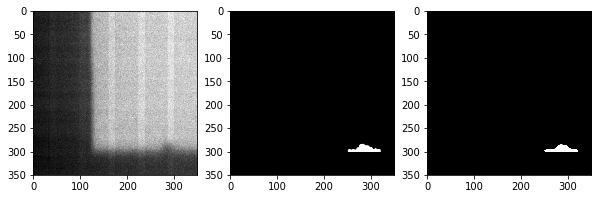

16: true_dist: 30, pred_dist: [27.113836]


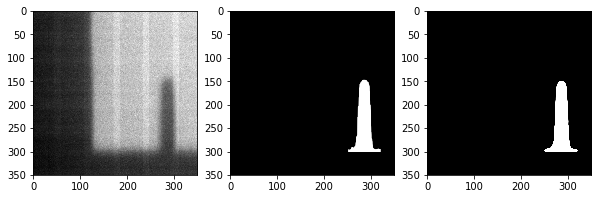

batch 2
1: true_dist: 35, pred_dist: [28.517807]


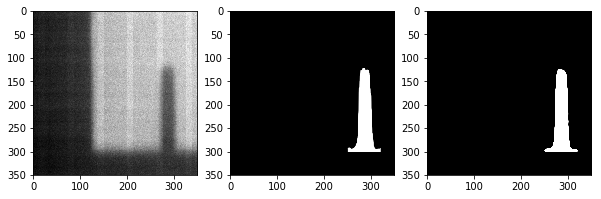

2: true_dist: 2, pred_dist: [1.7929621]


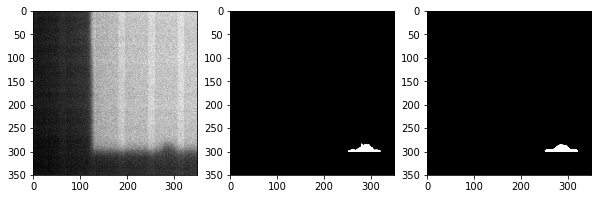

3: true_dist: 2, pred_dist: [1.8967768]


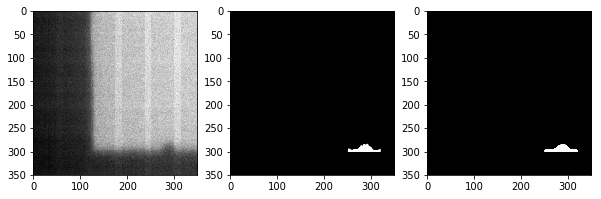

4: true_dist: 25, pred_dist: [25.174809]


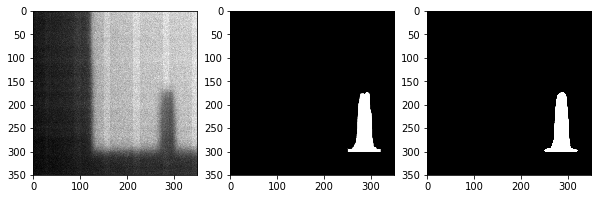

5: true_dist: 20, pred_dist: [20.457947]


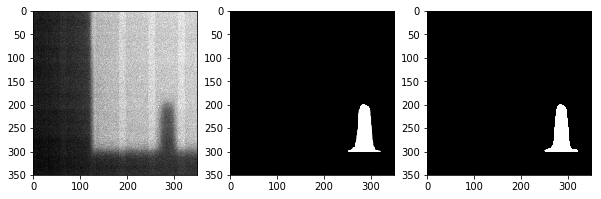

6: true_dist: 20, pred_dist: [20.183754]


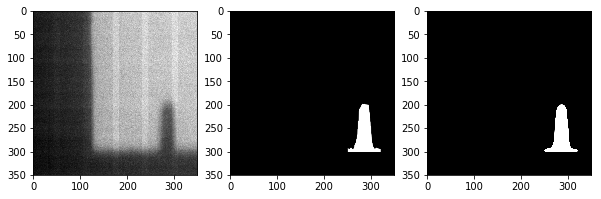

7: true_dist: 1, pred_dist: [1.1920737]


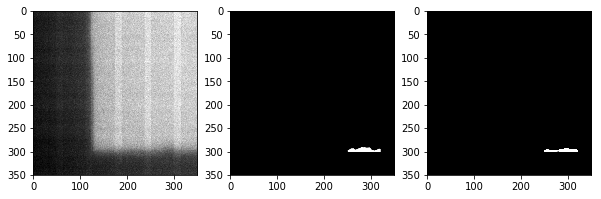

8: true_dist: 2, pred_dist: [1.8181431]


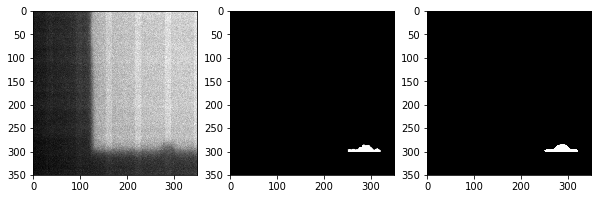

9: true_dist: 2, pred_dist: [1.8534122]


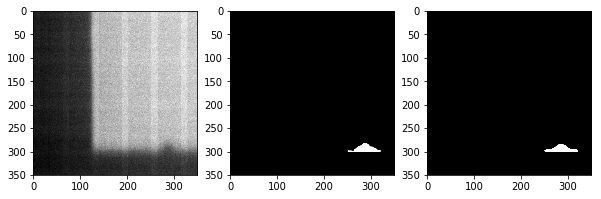

10: true_dist: 2, pred_dist: [1.7805564]


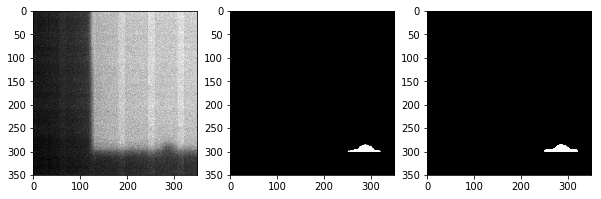

11: true_dist: 20, pred_dist: [20.387564]


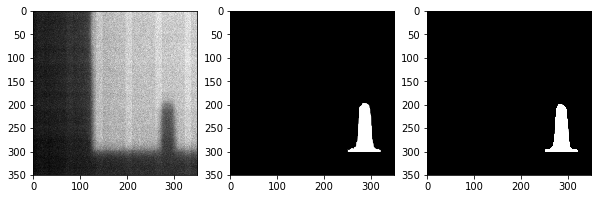

12: true_dist: 3, pred_dist: [2.8838863]


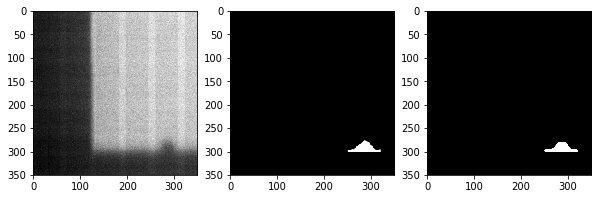

13: true_dist: 10, pred_dist: [9.72467]


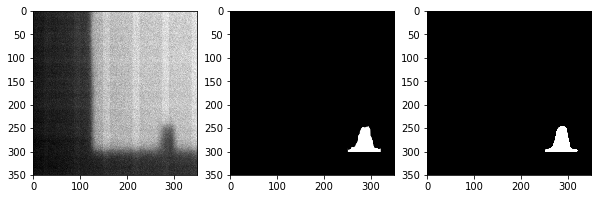

14: true_dist: 4, pred_dist: [4.192157]


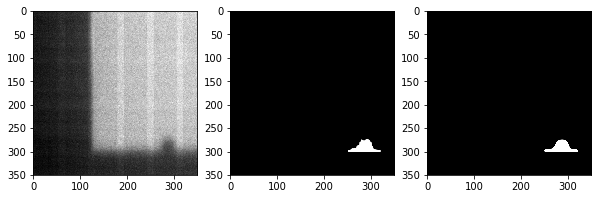

15: true_dist: 20, pred_dist: [20.284452]


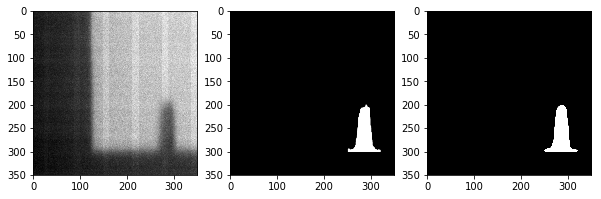

16: true_dist: 1, pred_dist: [1.079291]


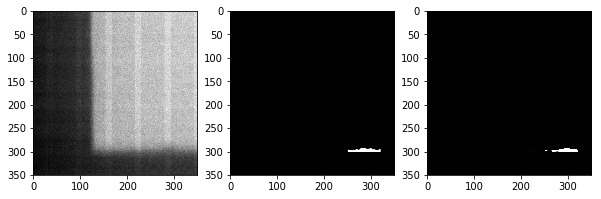

In [27]:
for i, batch in enumerate(dataset_loader):

    true_images, true_masks, true_dists = batch['image'].transpose(2,3), batch['mask'].transpose(2,3), batch['dist']
    pred_masks, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_cl, pr_msk, pr_cl) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = tr_cl
        pred_dist = pr_cl
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [28]:
y_true = []
y_pred = []
for i, batch in enumerate(dataset_loader):
    true_images, true_dists = batch['image'].transpose(2,3), batch['dist']
    _, pred_dists = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_dist, pr_dist) in enumerate(zip(true_images,
                                                 true_dists.cpu().detach().numpy(), 
                                                 pred_dists.cpu().detach().numpy())):
        true_dist = tr_dist
        pred_dist = pr_dist
        y_true.append(true_dist)
        y_pred.append(pred_dist)

batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 49
batch 50
batch 51
batch 52
batch 53
batch 54
batch 55
batch 56
batch 57
batch 58
batch 59
batch 60
batch 61
batch 62
batch 63
batch 64
batch 65
batch 66
batch 67
batch 68
batch 69
batch 70
batch 71
batch 72
batch 73
batch 74
batch 75
batch 76
batch 77
batch 78
batch 79
batch 80
batch 81
batch 82
batch 83
batch 84
batch 85
batch 86
batch 87
batch 88
batch 89
batch 90
batch 91
batch 92
batch 93
batch 94
batch 95
batch 96
batch 97
batch 98
batch 99
batch 100
batch 101
batch 102
batch 103
batch 104
batch 105
batch 106
batch 107
batch 108
batch 109
batch 110
batch 11

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
mean_squared_error(y_true, y_pred)

4.755954348994374

In [84]:
y_true[:10]

[25, 35, 30, 2, 3, 4, 25, 35, 3, 4]

In [99]:
y_pred = np.asarray(y_pred).flatten()

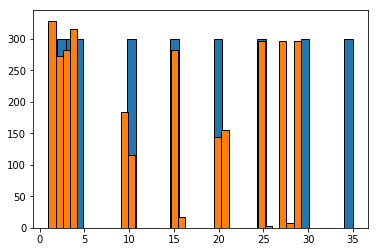

In [100]:
plt.hist(y_true, bins=35, edgecolor='k')
plt.hist(y_pred, bins=35, edgecolor='k')
plt.show()